# Working with functions in Azure OpenAI
This notebook shows how to use the Chat Completions API in combination with functions to extend the current capabilities of GPT models. GPT models, do not inherently support real-time interaction with external systems, databases, or files. However, functions can be used to do so.

Overview: <br>
`functions` is an optional parameter in the Chat Completion API which can be used to provide function specifications. This allows models to generate function arguments for the specifications provided by the user. 

Note: The API will not execute any function calls. Executing function calls using the outputed argments must be done by developers. 

## Setup

In [21]:
# if needed, install and/or upgrade to the latest version of the OpenAI Python library
#%pip install --upgrade openai

In [9]:
import openai
import json
import os
from dotenv import load_dotenv

# Load API key into environment variables
load_dotenv("../../.env")

# Load config values
with open(r'config.json') as config_file:
    config_details = json.load(config_file)
    
# Setting up the deployment name
deployment_id = config_details['DEPLOYMENT_ID']

# This is set to `azure`
openai.api_type = "azure"

# The API key for your Azure OpenAI resource.
openai.api_key = os.getenv("OPENAI_API_KEY")

# The base URL for your Azure OpenAI resource. e.g. "https://<your resource name>.openai.azure.com"
openai.api_base = config_details['OPENAI_API_BASE']

# Currently Chat Completion API have the following versions available: 2023-07-01-preview
openai.api_version = config_details['OPENAI_API_VERSION']

## 1.0 Test functions

This code calls the model with the user query and the set of functions defined in the functions parameter. The model then can choose if it calls a function. If a function is called, the content will be in a strigified JSON object. The function call that should be made and arguments are location in:  response[`choices`][0][`function_call`].

In [10]:
def get_function_call(messages, function_call = "auto"):
    # Define the functions to use
    functions = [
        {
            "name": "get_current_weather",
            "description": "Get the current weather in a given location",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The city and state, e.g. San Francisco, CA",
                    },
                    "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]},
                },
                "required": ["location"],
            },
        },
    ]

    # Call the model with the user query (messages) and the functions defined in the functions parameter
    response = openai.ChatCompletion.create(
        deployment_id = deployment_id,
        messages=messages,
        functions=functions,
        function_call=function_call, 
    )

    return response

### Forcing the use of a specific function or no function
By changing the value of the `functions` parameter you can allow the model to decide what function to use, force the model to use a specific function, or force the model to use no function.

In [11]:
first_message = [{"role": "user", "content": "What's the weather like in San Francisco?"}]
# 'auto' : Let the model decide what function to call
print("Let the model decide what function to call:")
print (get_function_call(first_message, "auto"))

# 'none' : Don't call any function 
print("Don't call any function:")
print (get_function_call(first_message, "none"))

# force a specific function call
print("Force a specific function call:")
print (get_function_call(first_message, function_call={"name": "get_current_weather"}))

Let the model decide what function to call:
{
  "id": "chatcmpl-7kz9kBOptBrbuJFkirC9CrJ79XmGM",
  "object": "chat.completion",
  "created": 1691432528,
  "model": "gpt-35-turbo",
  "prompt_annotations": [
    {
      "prompt_index": 0,
      "content_filter_results": {
        "hate": {
          "filtered": false,
          "severity": "safe"
        },
        "self_harm": {
          "filtered": false,
          "severity": "safe"
        },
        "sexual": {
          "filtered": false,
          "severity": "safe"
        },
        "violence": {
          "filtered": false,
          "severity": "safe"
        }
      }
    }
  ],
  "choices": [
    {
      "index": 0,
      "finish_reason": "function_call",
      "message": {
        "role": "assistant",
        "function_call": {
          "name": "get_current_weather",
          "arguments": "{\n  \"location\": \"San Francisco, CA\"\n}"
        }
      },
      "content_filter_results": {}
    }
  ],
  "usage": {
    "comple

## 2.0 Defining functions
Now that we know how to work with functions, let's define some functions in code so that we can walk through the process of using functions end to end.

### Function #1: Get current time

In [12]:
import pytz
from datetime import datetime

def get_current_time(location):
    try:
        # Get the timezone for the city
        timezone = pytz.timezone(location)

        # Get the current time in the timezone
        now = datetime.now(timezone)
        current_time = now.strftime("%I:%M:%S %p")

        return current_time
    except:
        return "Sorry, I couldn't find the timezone for that location."

In [13]:
get_current_time("America/New_York")

'02:22:39 PM'

In [ ]:
Get

In [63]:
import yfinance as yahooFinance
import seaborn as sns
import matplotlib.pyplot as plt
 
# Here We are getting Facebook financial information
# We need to pass FB as argument for that

def plot_stock_data(ticker_symbol: str, period: str, plot_type: str = "line"):
    ticker_info = yahooFinance.Ticker(ticker_symbol)
    ticker_df = ticker_info.history(period=period).reset_index()
    ticker_df["Date"] = pd.to_datetime(ticker_df["Date"], format="%Y-%m-%d")

    fig, ax = plt.subplots()
    if plot_type == "line":
        sns.lineplot(data=ticker_df, x="Date", y="Close", ax=ax)
    elif plot_type == "bar":
        sns.barplot(data=ticker_df, x="Date", y="Close", ax=ax)
    elif plot_type == "scatter":
        sns.scatterplot(data=ticker_df, x="Date", y="Close", ax=ax)
    else:
        raise ValueError(f"Unknown plot type: {plot_type}")
    
    x_dates = ticker_df['Date'].dt.strftime('%Y-%m-%d').sort_values().unique()
    ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
    return fig
    
    


### Function #2: Get stock market data
For simplicity, we're just hard coding some stock market data but you could easily edit the code to call out to an API to retrieve real-time data.

In [34]:
import pandas as pd
import json

def get_stock_market_data(index):
    available_indices = ["S&P 500", "NASDAQ Composite", "Dow Jones Industrial Average", "Financial Times Stock Exchange 100 Index"]

    if index not in available_indices:
        return "Invalid index. Please choose from 'S&P 500', 'NASDAQ Composite', 'Dow Jones Industrial Average', 'Financial Times Stock Exchange 100 Index'."

    # Read the CSV file
    data = pd.read_csv('stock_data.csv')

    # Filter data for the given index
    data_filtered = data[data['Index'] == index]

    # Remove 'Index' column
    data_filtered = data_filtered.drop(columns=['Index'])

    # Convert the DataFrame into a dictionary
    hist_dict = data_filtered.to_dict()

    for key, value_dict in hist_dict.items():
        hist_dict[key] = {k: v for k, v in value_dict.items()}

    return json.dumps(hist_dict)


In [35]:
print(get_stock_market_data("NASDAQ Composite"))

{"Date": {"2": "2023-07-12", "3": "2023-07-13"}, "Open": {"2": 14000.65, "3": 14100.11}, "High": {"2": 14200.06, "3": 14250.0}, "Low": {"2": 13800.08, "3": 14000.67}, "Close": {"2": 14100.44, "3": 14050.81}, "Volume": {"2": 4000000, "3": 4200000}}


### Function #3: Calculator 

In [36]:
import math

def calculator(num1, num2, operator):
    if operator == '+':
        return str(num1 + num2)
    elif operator == '-':
        return str(num1 - num2)
    elif operator == '*':
        return str(num1 * num2)
    elif operator == '/':
        return str(num1 / num2)
    elif operator == '**':
        return str(num1 ** num2)
    elif operator == 'sqrt':
        return str(math.sqrt(num1))
    else:
        return "Invalid operator"

In [37]:
print(calculator(5, 5, '+'))

10


## 3.0 Calling a function using GPT

Steps for Function Calling: 

1. Call the model with the user query and a set of functions defined in the functions parameter.
2. The model can choose to call a function; if so, the content will be a stringified JSON object adhering to your custom schema (note: the model may generate invalid JSON or hallucinate parameters).
3. Parse the string into JSON in your code, and call your function with the provided arguments if they exist.
4. Call the model again by appending the function response as a new message, and let the model summarize the results back to the user.

### 3.1 Describe the functions so that the model knows how to call them

In [57]:
functions = [
        {
            "name": "get_current_time",
            "description": "Get the current time in a given location",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The location name. The pytz is used to get the timezone for that location. Location names should be in a format like America/New_York, Asia/Bangkok, Europe/London",
                    }
                },
                "required": ["location"],
            },
        },
        {
            "name": "get_stock_market_data",
            "description": "Get the stock market data for a given index",
            "parameters": {
                "type": "object",
                "properties": {
                    "index": {
                        "type": "string",
                        "enum": ["S&P 500", "NASDAQ Composite", "Dow Jones Industrial Average", "Financial Times Stock Exchange 100 Index"]},
                },
                "required": ["index"],
            },    
        },
        {
            "name": "plot_stock_data",
            "description": "Create plots for current stock market ticker symbols",
            "parameters": {
                "type": "object",
                "properties": {
                    "ticker_symbol": {
                        "type": "string",
                        "description": "The ticker symbol for the stock."
                    },
                    "period": {
                        "type": "string",
                        "enum": ["1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "10y", "ytd"]
                    },
                    "plot_type": {
                        "type": "string",
                        "enum": ["line", "bar", "scatter"]
                    }
                },
                "required": ["ticker_symbol", "period", "plot_type"],
            },    
        },
        {
            "name": "calculator",
            "description": "A simple calculator used to perform basic arithmetic operations",
            "parameters": {
                "type": "object",
                "properties": {
                    "num1": {"type": "number"},
                    "num2": {"type": "number"},
                    "operator": {"type": "string", "enum": ["+", "-", "*", "/", "**", "sqrt"]},
                },
                "required": ["num1", "num2", "operator"],
            },
        }
    ]

available_functions = {
            "get_current_time": get_current_time,
            "get_stock_market_data": get_stock_market_data,
            "plot_stock_data": plot_stock_data,
            "calculator": calculator,
        } 

### 3.2 Define a helper function to validate the function call
It's possible that the models could generate incorrect function calls so it's important to validate the calls. Here we define a simple helper function to validate the function call although you could apply more complex validation for your use case.

In [58]:
import inspect

# helper method used to check if the correct arguments are provided to a function
def check_args(function, args):
    sig = inspect.signature(function)
    params = sig.parameters

    # Check if there are extra arguments
    for name in args:
        if name not in params:
            return False
    # Check if the required arguments are provided 
    for name, param in params.items():
        if param.default is param.empty and name not in args:
            return False

    return True

In [61]:
def run_conversation(messages, functions, available_functions, deployment_id):
    # Step 1: send the conversation and available functions to GPT

    response = openai.ChatCompletion.create(
        deployment_id=deployment_id,
        messages=messages,
        functions=functions,
        function_call="auto", 
    )
    response_message = response["choices"][0]["message"]


    # Step 2: check if GPT wanted to call a function
    if response_message.get("function_call"):
        print("Recommended Function call:")
        print(response_message.get("function_call"))
        print()
        
        # Step 3: call the function
        # Note: the JSON response may not always be valid; be sure to handle errors
        
        function_name = response_message["function_call"]["name"]
        
        # verify function exists
        if function_name not in available_functions:
            return "Function " + function_name + " does not exist"
        function_to_call = available_functions[function_name]  
        
        # verify function has correct number of arguments
        function_args = json.loads(response_message["function_call"]["arguments"])
        if check_args(function_to_call, function_args) is False:
            return "Invalid number of arguments for function: " + function_name
        function_response = function_to_call(**function_args)
        
        print("Output of function call:")
        print(function_response)
        print()
        
        if isinstance(function_response, str):
            # Step 4: send the info on the function call and function response to GPT
            
            # adding assistant response to messages
            messages.append(
                {
                    "role": response_message["role"],
                    "name": response_message["function_call"]["name"],
                    "content": response_message["function_call"]["arguments"],
                }
            )

            # adding function response to messages
            messages.append(
                {
                    "role": "function",
                    "name": function_name,
                    "content": function_response,
                }
            )  # extend conversation with function response

            print("Messages in second request:")
            for message in messages:
                print(message)
            print()

            second_response = openai.ChatCompletion.create(
                messages=messages,
                deployment_id=deployment_id
            )  # get a new response from GPT where it can see the function response

            return second_response
        else:
            return first_response

Recommended Function call:
{
  "name": "plot_stock_data",
  "arguments": "{\n\"ticker_symbol\": \"MSFT\",\n\"period\": \"1mo\",\n\"plot_type\": \"line\"\n}"
}



AttributeError: Can only use .dt accessor with datetimelike values

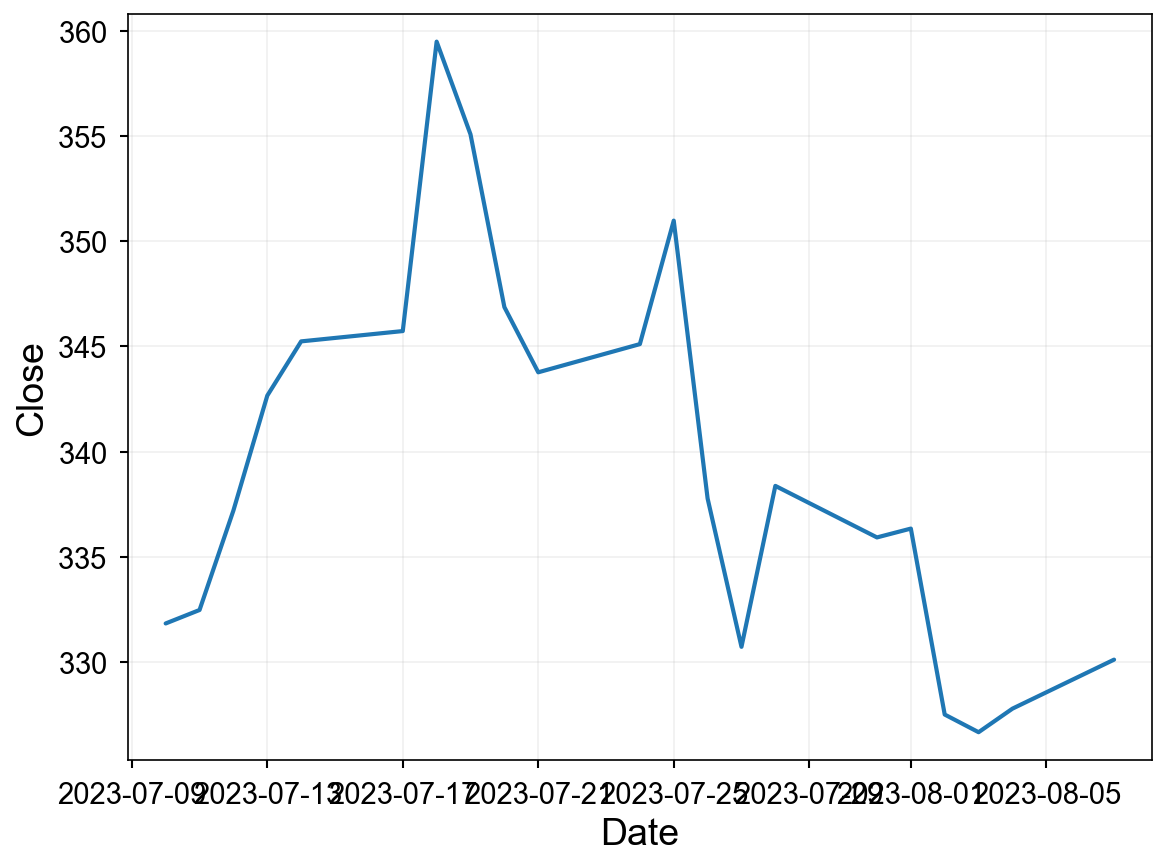

In [62]:
messages = [{"role": "user", "content": "Make a line plot of the stock price for MSFT."}]
assistant_response = run_conversation(messages, functions, available_functions, deployment_id)
print(assistant_response['choices'][0]['message'])

### 4.0 Calling multiple functions together
In some cases, you may want to string together multiple function calls to get the desired result. We modified the `run_conversation()` function above to allow multiple function calls to be made.

In [35]:
def run_multiturn_conversation(messages, functions, available_functions, deployment_id):
    # Step 1: send the conversation and available functions to GPT

    response = openai.ChatCompletion.create(
        deployment_id=deployment_id,
        messages=messages,
        functions=functions,
        function_call="auto", 
        temperature=0
    )

    # Step 2: check if GPT wanted to call a function
    while response["choices"][0]["finish_reason"] == 'function_call':
        response_message = response["choices"][0]["message"]
        print("Recommended Function call:")
        print(response_message.get("function_call"))
        print()
        
        # Step 3: call the function
        # Note: the JSON response may not always be valid; be sure to handle errors
        
        function_name = response_message["function_call"]["name"]
        
        # verify function exists
        if function_name not in available_functions:
            return "Function " + function_name + " does not exist"
        function_to_call = available_functions[function_name]  
        
        # verify function has correct number of arguments
        function_args = json.loads(response_message["function_call"]["arguments"])
        if check_args(function_to_call, function_args) is False:
            return "Invalid number of arguments for function: " + function_name
        function_response = function_to_call(**function_args)
        
        print("Output of function call:")
        print(function_response)
        print()
        
        # Step 4: send the info on the function call and function response to GPT
        
        # adding assistant response to messages
        messages.append(
            {
                "role": response_message["role"],
                "name": response_message["function_call"]["name"],
                "content": response_message["function_call"]["arguments"],
            }
        )

        # adding function response to messages
        messages.append(
            {
                "role": "function",
                "name": function_name,
                "content": function_response,
            }
        )  # extend conversation with function response

        print("Messages in next request:")
        for message in messages:
            print(message)
        print()

        response = openai.ChatCompletion.create(
            messages=messages,
            deployment_id=deployment_id,
            function_call="auto",
            functions=functions,
            temperature=0
        )  # get a new response from GPT where it can see the function response

    return response

In [36]:
# Can add system prompting to guide the model to call functions and perform in specific ways
next_messages = [{"role": "system", "content": "Assistant is a helpful assistant that helps users get answers to questions. Assistant has access to several tools and sometimes you may need to call multiple tools in sequence to get answers for your users."}]
next_messages.append({"role": "user", "content": "How much did S&P 500 change between July 12 and July 13? Use the calculator."})

assistant_response = run_multiturn_conversation(next_messages, functions, available_functions, deployment_id)
print("Final Response:")
print(assistant_response["choices"][0]["message"])
print("Conversation complete!")  

Recommended Function call:
{
  "name": "get_stock_market_data",
  "arguments": "{\n  \"index\": \"S&P 500\"\n}"
}

Output of function call:
{"Date": {"0": "2023-07-12", "1": "2023-07-13"}, "Open": {"0": 4300.25, "1": 4325.55}, "High": {"0": 4350.32, "1": 4350.0}, "Low": {"0": 4200.2, "1": 4300.98}, "Close": {"0": 4325.74, "1": 4310.33}, "Volume": {"0": 3500000, "1": 3600000}}

Messages in next request:
{'role': 'system', 'content': 'Assistant is a helpful assistant that helps users get answers to questions. Assistant has access to several tools and sometimes you may need to call multiple tools in sequence to get answers for your users.'}
{'role': 'user', 'content': 'How much did S&P 500 change between July 12 and July 13? Use the calculator.'}
{'role': 'assistant', 'name': 'get_stock_market_data', 'content': '{\n  "index": "S&P 500"\n}'}
{'role': 'function', 'name': 'get_stock_market_data', 'content': '{"Date": {"0": "2023-07-12", "1": "2023-07-13"}, "Open": {"0": 4300.25, "1": 4325.55